# Applying the Ocean function to geometries and generating grids

A common application is to test whether a certain geometry lies over the ocean and/or to generate an rasterized ocean mask.

The [natural earth collection](https://www.naturalearthdata.com) contains ocean geometries. However, naively testing for inclusion of a geometry can take a very long time since the polygon associated with Asia a has many points and is not optimized for inclusion tests. Furthermore, for most applications, the isolated Capsian Sea may also not be considered to belong to the ocean.

For these reasons a dedicated table can be generated in geoslurp, which will speed up inclusion searches and raster generation. This will be described below.

The idea is that the coastal polygons are subdivided in smaller manageable pieces with PostGIS ([ST_subdivide](https://postgis.net/docs/ST_Subdivide.html)) and a geospatial index is generated to speed up queries.

In [64]:
from geoslurp.config.catalogue import DatasetCatalogue
from geoslurp.db import Settings
from geoslurp.config import setInfoLevel

from geoslurp.db import geoslurpConnect
from geoslurp.tools.shapelytools import gdal2rastio
from geoslurp.tools.pandas import *
import rioxarray
setInfoLevel()

gpcon=geoslurpConnect(readonly_user=False) # this will be a connection based on the readonly userfrom geoslurp.db.geo

#Some datasets need info from the server side settings so we need to load these
conf=Settings(gpcon)

#catalogue
gscat=DatasetCatalogue()

tocea="natearth.ne_10m_oceanfunc"
#original table
tocea_orig="natearth.ne_10m_ocean"



Let's pull and register the dedicated ocean function table
```
geoslurper.py -v --pull --register "natearth.ne_10m_oceanfunc"
```

Or alternatively in Python:

In [8]:
dsoceanf=gscat.getDsetClass(conf, tocea)(gpcon)
dsoceanf.pull()
dsoceanf.register()

/usr/lib/python3.12/site-packages/osgeo/osr.py:410: FutureWarning: Neither osr.UseExceptions() nor osr.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(
Geoslurp-INFO: creating table natearth.ne_10m_oceanfunc and index, this can take a while..
Geoslurp-INFO: Done..


In [37]:
# Also register the geoslurp gs_maskgeom function, which is needed to rasterize polygons
dfmgeom=gscat.getDFuncClass(conf, "public.gs_maskgeom")(gpcon)
dfmgeom.register()

Geoslurp-INFO: Registering (overload) of gs_maskgeom function
Geoslurp-INFO: Registering (overload) of gs_maskgeom function


## Example 1: Generate a global 0.125 degree equidistant raster

Note: The generated grid can also be found on [this github repository](https://github.com/strawpants/geoshapes)

In [41]:
resolution=0.125
# The query, will generate a joint raster from the dedicated ocean geometries and generates a TIFF object
#NOTE that the ST_UNION is needed to merge the rasters arising from the subidvided polygon in a consistent sense
qry=f"SELECT ST_ASGDALRaster(ST_Union(gs_maskgeom(geom::geometry,0.125)),'GTiff') AS rast FROM {tocea};"

#load the query result in a pardas dataframe
oceanrast=pd.DataFrame.gslrp.load(gpcon,qry)

# use rioxarray and rasterio to read the resulting raster as an xarray dataarray
with gdal2rastio(oceanrast.loc[0]["rast"]) as memfile:
    with memfile.open() as rio:
        daocean=rioxarray.open_rasterio(rio)

display(daocean)

<xarray.DataArray (band: 1, y: 1403, x: 2882)>
[4043446 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.8 -179.6 ... 179.9 180.0 180.1
  * y            (y) float64 90.0 89.88 89.75 89.62 ... -85.0 -85.12 -85.25
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

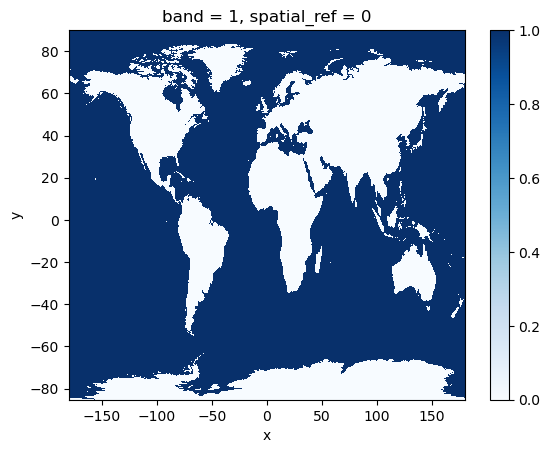

In [45]:
# Create a quick plot of the result and write it to a netcdf file
daocean.plot(cmap='Blues')
oceanfout=f"/tmp/ne_10m_oceangrid_{resolution}.nc"
daocean.squeeze("band").rename(x="latitude",y="longitude").to_netcdf(oceanfout)

## Example 2: Use the optimized table for other queries

In [81]:
wkttest="Polygon ((-15.19112857609935929 54.39984018637987617, 33.96385536287604623 45.7254312559724525, 60.4001492460224938 -5.63257717326514751, -83.34719874358626157 4.00565497163198359, -15.19112857609935929 54.39984018637987617))"
from shapely import from_wkt
area=from_wkt(wkttest)
seed=1000
npoints=2000

# generate two queries

# Fast version using the index
qryfast=f"""CREATE TEMPORARY TABLE testpnts AS SELECT (ST_dump(ST_generatePoints(geom,{npoints},{seed}))).geom AS geom FROM (SELECT ST_GeomfromText('{wkttest}',4326) AS geom) AS s;
    SELECT tst.geom AS geom from testpnts AS tst INNER JOIN {tocea} as oce ON ST_within(tst.geom,oce.geom);
    """
#slow version using the original input table
qryslow=f"""CREATE TEMPORARY TABLE testpnts AS SELECT (ST_dump(ST_generatePoints(geom,{npoints},{seed}))).geom AS geom FROM (SELECT ST_GeomfromText('{wkttest}',4326) AS geom) AS s;
    SELECT tst.geom AS geom from testpnts AS tst INNER JOIN {tocea_orig} as oce ON ST_within(tst.geom,oce.geom::geometry);
    """




In [82]:
%%time
pntsslow=pd.DataFrame.gslrp.load(gpcon,qryslow)

CPU times: user 55.5 ms, sys: 3.06 ms, total: 58.6 ms
Wall time: 43.3 s


In [83]:
%%time
pntsfast=pd.DataFrame.gslrp.load(gpcon,qryfast)

CPU times: user 55.7 ms, sys: 94 μs, total: 55.8 ms
Wall time: 165 ms


# Conclusion: An indexed and subdivided geometry table speeds up the ocean queries considerably
For this particular example and database, quering 2000 points was sped up to 165 ms from 43 seconds (factor 260x)

Let's visualize the results:

(-10.0, 60.0)

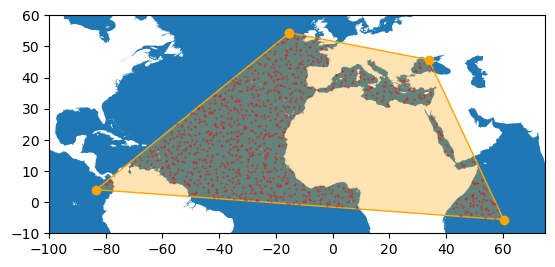

In [90]:
from shapely.plotting import plot_polygon
qry=f"SELECT geom as geom FROM {tocea_orig};"
#load the query result in a pandas dataframe
dfoce=pd.DataFrame.gslrp.load(gpcon,qry)

ax=dfoce.plot()
plot_polygon(area,ax=ax,color='orange')

pntsslow.plot(ax=ax,color='red',markersize=0.1)
ax.set_xlim([-100,75])
ax.set_ylim([-10,60])

